# A2: Bias in data
## Dane Jordan

Import necessary libraries that will be used

In [1]:
import json
import matplotlib.pyplot as plt
import pandas as pd
import requests

%matplotlib inline


### Getting the article and population data
The wikipedia article dataset, "Politicians by Country from the English-language Wikipedia," was obtained from Figshare on 10/29/2017. It was downloaded as a zipped folder and the `page_data.csv` was extracted from /country/data.

https://figshare.com/articles/Untitled_Item/5513449

- CC-BY 4.0

The population dataset, "Population Mid-2015," was obtained from the Population Reference Bureau on 10/27/2017. The link for this data is NOT provided and it is NOT included in the repository as it is copyrighted.

- Copyright © 2016, Population Reference Bureau. All rights reserved.

The two datasets are read into pandas DataFrames below. The revid for the wikipedia article dataset is set to be a string for merging purposes later on. The population dataset excludes the first line which is a title for the dataset and removes all commas in numbers (population counts).

In [2]:
# read in the data from the page_data.csv file
page_data = pd.read_csv('../data_raw/page_data.csv', dtype={'rev_id': str})

# read in the data from the population csv file
population_data = pd.read_csv('../data_raw/Population Mid-2015.csv', header=1, thousands=',')


### Getting article quality predictions using ORES
Data was gathered from the ORES (Objective Revision Evaluation Service) API, 2017. It was obtained on 10/29/2017. While no license was found on ORES, it has been attributed to the same license as the Wikimedia Foundation.

https://wikimediafoundation.org/wiki/Terms_of_Use/en

- CC-BY-SA 3.0

Passing the rev_ids through the ORES API, could be done individually or in batches. Based on the number of calls to the API, it is much quicker to batch the revids, however, the API only accepts a certain number of revids per call. After some trial and error, the acceptable number of revids seemed to be anything less than 140. For safety the revids were batched in groups of 100. Below a list of lists is created where each nested list contains 100 revids.

In [3]:
# create a list of lists where each nested list contains 100 revids delimited by '|'
revid_list = []
for i in range(len(page_data)):
    if i % 100 == 0:
        revid_list.insert(i // 100, [str(page_data['rev_id'][i])])
    else:
        revid_list[i // 100].append(str(page_data['rev_id'][i]))


Next, two lists are created. One to store the article quality prediction and another to account for any missing revids. This was implemented after the wikipedia article dataset was updated and the ORES API call returned an error--debugging yielded the addition.

The revid list created above is then looped such that the API is sent a request with a batch of 100 revids. After each API call, the response is looped and each revid is parsed to obtain the prediction. That prediction is appended, as well as the revid, to the predictions list. If no prediction is found and a KeyError is returned, an 'NA' along with the revid is appended to the predictions list and the revid alone is appended to the missing revids list.

__NOTE: At the time the API was called and the cleaned dataset was created only two revids were missing. The ORES API call has been rerun since this time and is now showing more missing revids. The cleaned dataset is imported in a later step, and was created using the ORES API response from 10/29/2017.__

In [4]:
# initialize a list to store the prediction values
predictions = []
missing_revid = []

# loop through the the revid lists (batches of 100) and call the api
for i in range(len(revid_list)):
    endpoint = 'https://ores.wikimedia.org/v3/scores/{context}?models={models}&revids={revids}'

    params = {'context' : 'enwiki',
              'models' : 'wp10',
              'revids' : '|'.join(revid_list[i])
              }

    api_call = requests.get(endpoint.format(**params))

    response = api_call.json()
    
    # loop through the response for the batch of 100 revids and append the prediction to the prediction list
    for j in response['enwiki']['scores']:
        
        # check for missing revids (potentially articles that have been deleted)
        try:
            predictions.append([j, response['enwiki']['scores'][j]['wp10']['score']['prediction']])
            
        # if artile is missing, attribute an 'NA' prediction and store the missing revid
        except KeyError:
            predictions.append([j, 'NA'])
            missing_revid.append(j)

# print the count and list of missing revids
print('There were a total of ' + str(len(missing_revid)) + ' missing revids. They are as follows: ' + str(sorted(missing_revid)))


There were a total of 4 missing revids. They are as follows: ['806811023', '807367030', '807367166', '807484325']


### Combining the datasets
The predictions obtained from ORES are loaded into a pandas DataFrame with column names added. Duplicate revids were originally dropped from this DataFrame prior to the wikipedia article dataset being updated. The predictions obtained from ORES and the page_data obtained from Figshare are then merged on the revid, essentially appending the article quality prediction to the page_data. This new page_data is then merged with the population dataset on the country/Location ('country' is the attribute name in page_data and 'Location' is the attribute name in population_data) to obtain a cleaned dataset that is in the below format:

column name | value
--- | ---
country | str
article_name | str
revision_id | str
article_quality | str
population | str

In [5]:
# convert predictions to a dataframe and add column names
predictions_df = pd.DataFrame(predictions)
predictions_df.columns = ['revid', 'prediction']

# drop duplicates (this was included for the duplicate revids--no longer needed with the updated page_data.csv)
predictions_df = predictions_df.drop_duplicates()

# merge the predictions with the page_data
page_data_new = page_data.merge(predictions_df, how='left', left_on='rev_id', right_on='revid')
page_data_new = page_data_new.drop('revid', axis=1)

# merge the two data sets (page_data_new and population_data), add specified column names, and reorder columns
combined_data = page_data_new.merge(population_data[['Location', 'Data']], left_on='country', right_on='Location')
combined_data = combined_data.drop('Location', axis=1)
combined_data.columns = ['article_name', 'country', 'revision_id', 'article_quality', 'population']
combined_data = combined_data[['country', 'article_name', 'revision_id', 'article_quality', 'population']]

# output file to csv
# combined_data.to_csv('../data_clean/combined_data.csv', index=False)


### Analysis
So as to reproduce the analysis, the cleaned data is loaded from a saved static file. The analysis could potentially change depending on data sources from earlier, such as noted regarding the ORES API response.

First all of the countries are identified and duplicates are removed. Then the number of articles for each country are counted using a `groupby` (__NOTE: This includes articles with missing revids from the API call__). Next, the high-quality articles are returned in a similar fashion, again listing the country and the count, with countries that have no high-quality articles having a '0' for the count. The population for each country is obtained by using a `groupby` and retrieving the `max` which is also the `min`, but since there is only one possible population value assigned to each country, this does not matter.

Now that the data has been obtained in a per country format, the simple calculation is performed for articles per population and percentage of high-quality articles for each country and loaded into an analysis DataFrame with the following structure:

column name | value
--- | ---
country | str
articles_per_population | int
percentage_hq_articles | int

In [6]:
# load the cleaned data
combined_data = pd.read_csv('../data_clean/combined_data.csv',
                            dtype={'revision_id': str},
                            encoding='ISO-8859-1')

# identify all of the countries (removing duplicates)
country = pd.DataFrame({'country': sorted(combined_data['country'].unique())})

# count the total number of articles (NOTE: this includes articles with missing revids from the api call) per country
num_articles = combined_data.groupby('country')['article_name'].count().reset_index()
num_articles.columns = ['country', 'count']

#  count the number of 'high-quality' articles per country
hq_articles = combined_data[(combined_data['article_quality'] == 'FA') |
                            (combined_data['article_quality'] == 'GA')
                           ].groupby('country')['article_quality'].count()
hq_articles = hq_articles.reindex(country['country'], fill_value=0).reset_index()
hq_articles.columns = ['country', 'count']

# get the population per country
population = combined_data.groupby('country')['population'].max().reset_index()

# calculate the two 'analysis' variables:
# 1. proportion (as a percentage) of articles-per-population for each country
# 2. proportion (as a percentage) of high-quality articles for each country
articles_per_population = pd.DataFrame({'country': country['country'],
                                        'percentage': 100*(num_articles['count'] / population['population'])})
percentage_hq_articles = pd.DataFrame({'country': country['country'],
                                       'percentage': 100*(hq_articles['count'] / num_articles['count'])})

# combine the two 'analysis' variables into a dataframe
analysis = pd.DataFrame({'country': country['country'],
                         'articles_per_population': articles_per_population['percentage'],
                         'percentage_hq_articles': percentage_hq_articles['percentage']
                        })

# reorder the columns in the dataframe
analysis = analysis[['country', 'articles_per_population', 'percentage_hq_articles']]


### Tables
The following function converts a 2-column pandas DataFrame into a markdown style table for easy implementation on github or any other markdown environment.

In [7]:
def convert_table_markdown(df, filename):
    
    '''
    This function takes in a 2-column dataframe and converts it into a markdown table
    :param df: pandas dataframe
    :param filename: str saved file name
    '''
    
    df_table = df.columns[0] + ' | ' + df.columns[1] + ' (%)' + '\n---' + ' | ' + '---'
    for i in range(len(df)):
        df_table += '\n' + df[df.columns[0]][i] + ' | ' + '%f' % round(df[df.columns[1]][i], 6) + '%'
    
    df_markdown = open('../analysis/' + filename + '.txt', 'w')
    df_markdown.write(df_table)
    df_markdown.close()


Here the four visualizations are created by sorting the analysis DataFrame, either ascending or descending depending on if it is for the highest-10 or lowest-10, and keeping only those first 10 records.

__NOTE: Upon performing this operation it was seen that there were more than 10 countries with 0.00% high-quality articles. As such, a bar graph representation of these would not be useful and instead a list was created. Also, as all 10 showed 0.00%, the analysis was performed in such a way that it listed all countries with 0.00% high-quality article percentage so as not to give favor to particular countries.__

In [8]:
# sort the analysis dataframe based on the key attributes and only return the first 10
viz1 = analysis.sort_values('articles_per_population', ascending=False)[['country', 'articles_per_population']][0:10].reset_index(drop=True)
viz2 = analysis.sort_values('articles_per_population')[['country', 'articles_per_population']][0:10].reset_index(drop=True)
viz3 = analysis.sort_values('percentage_hq_articles', ascending=False)[['country', 'percentage_hq_articles']][0:10].reset_index(drop=True)

# this visualization will be handled only as a table, since there are more than 10 countries with no high-quality articles
viz4 = analysis[analysis['percentage_hq_articles'] == 0][['country', 'percentage_hq_articles']].sort_values('country').reset_index(drop=True)

# convert visualizaions to a markdown style tables (text files to be included in analysis README.md)
# convert_table_markdown(viz1, 'viz1')
# convert_table_markdown(viz2, 'viz2')
# convert_table_markdown(viz3, 'viz3')
# convert_table_markdown(viz4, 'viz4')


The bar plots were included as they has already been created prior to the update that they were not necessary for the purposes of the assignment.

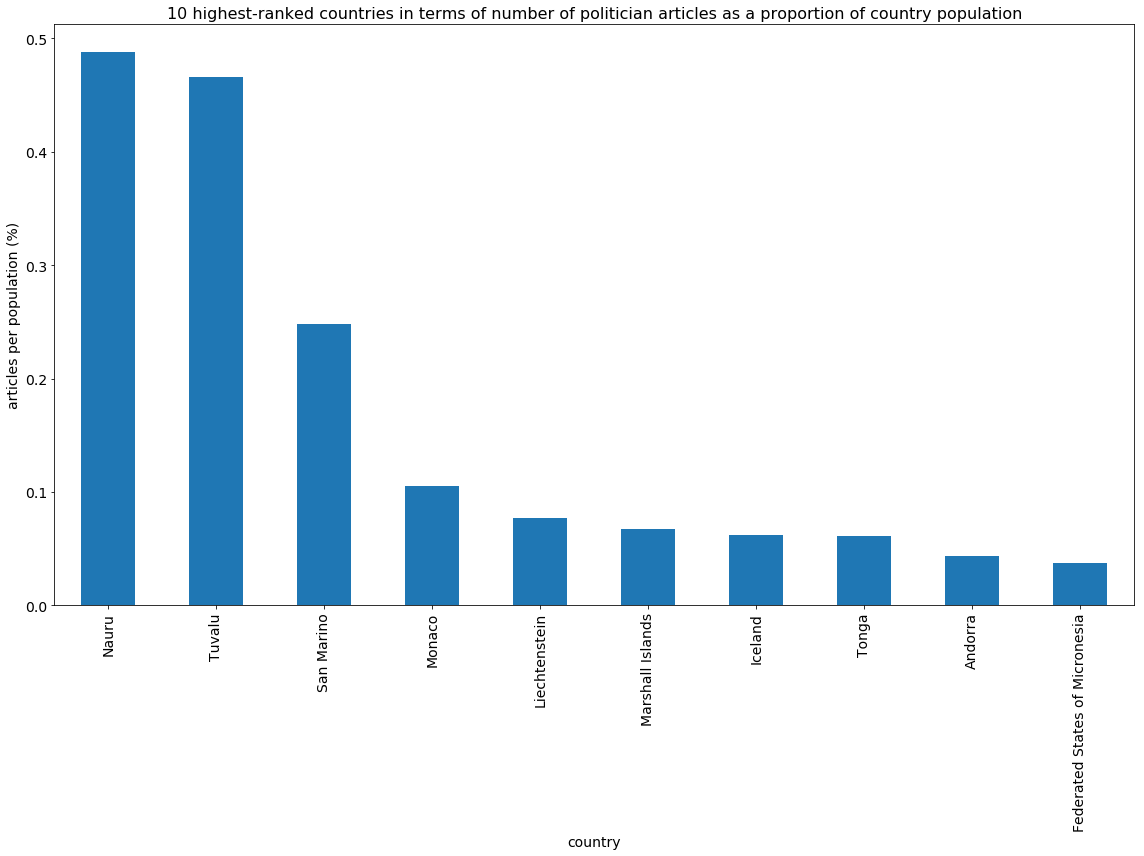

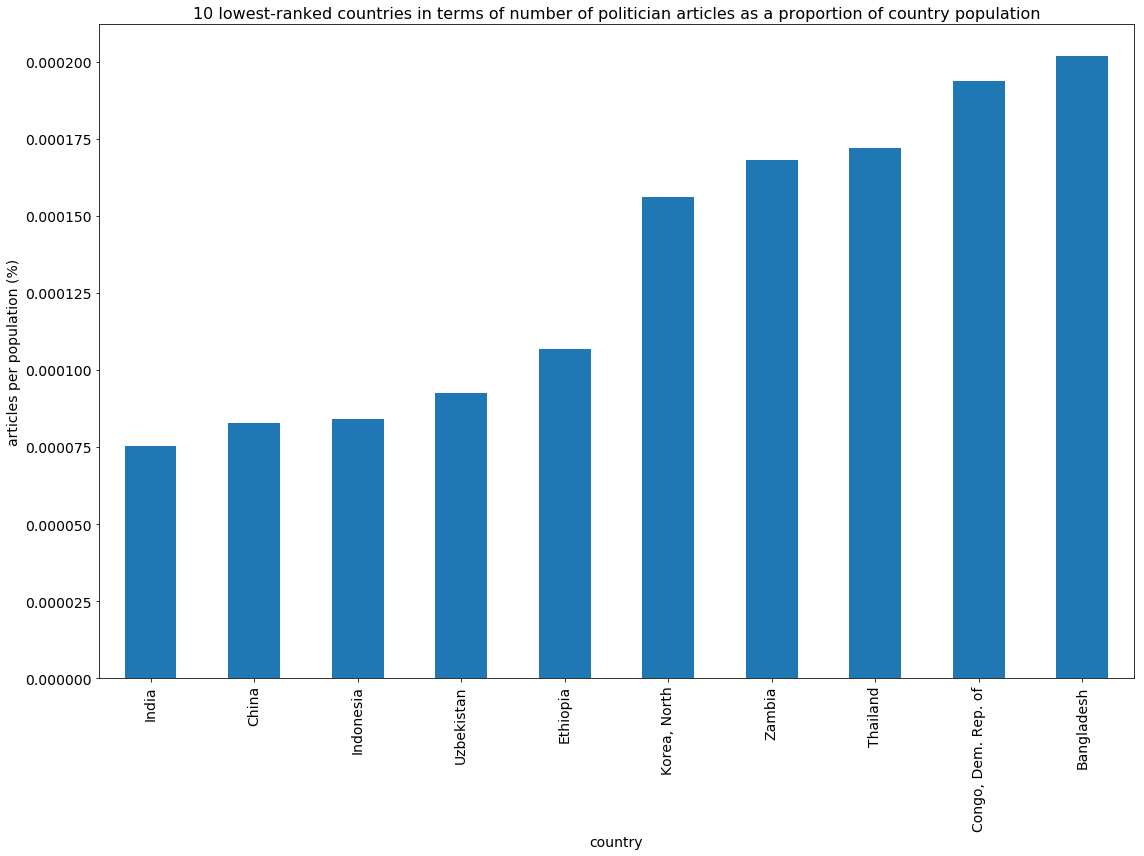

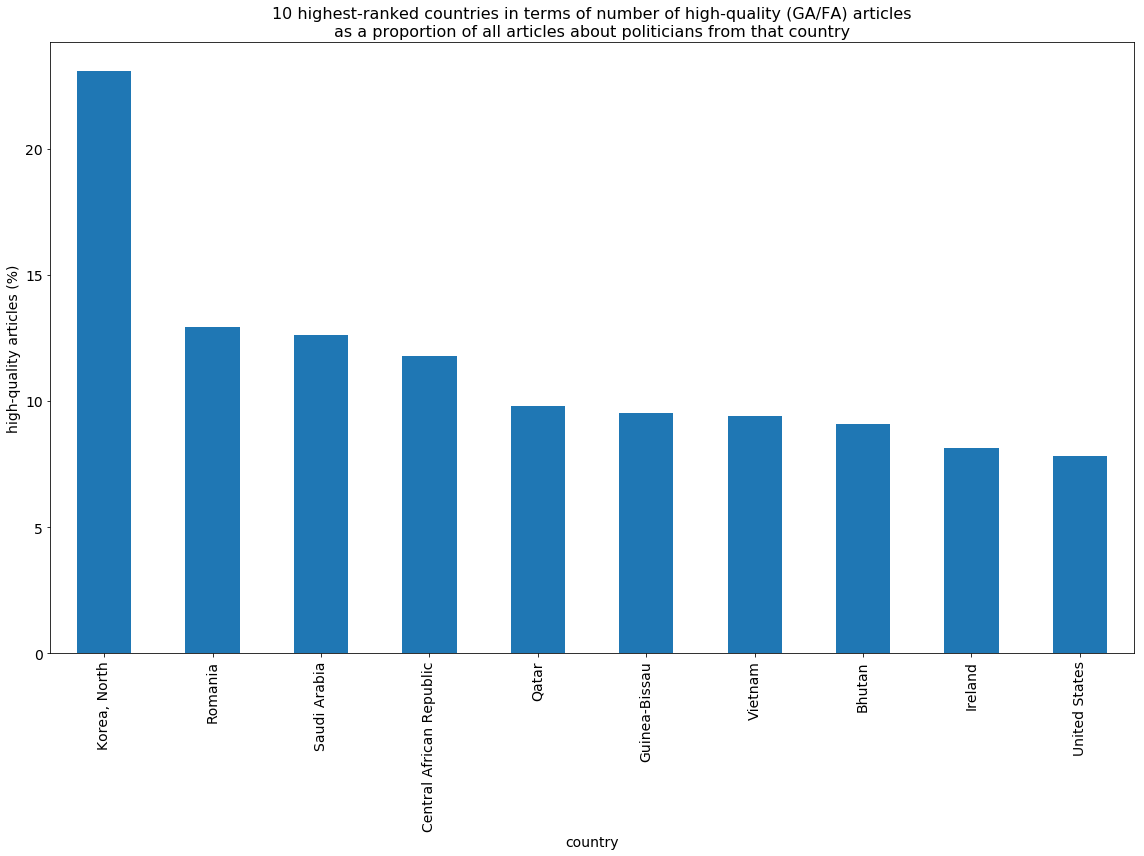

In [9]:
# create bar plots for the first three visualizations and save the images

ax1 = viz1.plot(x='country', kind='bar', figsize=(16, 12), legend=False, fontsize=14)
plt.title('10 highest-ranked countries in terms of number of politician articles as a proportion of country population', fontsize=16)
plt.xlabel('country', fontsize=14)
plt.ylabel('articles per population (%)', fontsize=14)
plt.tight_layout()
# plt.savefig('../analysis/viz1.png')

ax2 = viz2.plot(x='country', kind='bar', figsize=(16, 12), legend=False, fontsize=14)
plt.title('10 lowest-ranked countries in terms of number of politician articles as a proportion of country population', fontsize=16)
plt.xlabel('country', fontsize=14)
plt.ylabel('articles per population (%)', fontsize=14)
plt.tight_layout()
# plt.savefig('../analysis/viz2.png')

ax3 = viz3.plot(x='country', kind='bar', figsize=(16, 12), legend=False, fontsize=14)
plt.title('10 highest-ranked countries in terms of number of high-quality (GA/FA) articles\n'
          'as a proportion of all articles about politicians from that country', fontsize=16)
plt.xlabel('country', fontsize=14)
plt.ylabel('high-quality articles (%)', fontsize=14)
plt.tight_layout()
# plt.savefig('../analysis/viz3.png')


#### 10 highest-ranked countries in terms of number of politician articles as a proportion of country population

In [11]:
viz1

,country,articles_per_population
0,Nauru,0.488029
1,Tuvalu,0.466102
2,San Marino,0.248485
3,Monaco,0.105020
4,Liechtenstein,0.077189
5,Marshall Islands,0.067273
6,Iceland,0.062268
7,Tonga,0.060987
8,Andorra,0.043590
9,Federated States of Micronesia,0.036893


#### 10 lowest-ranked countries in terms of number of politician articles as a proportion of country population

In [12]:
viz2

,country,articles_per_population
0,India,0.000075
1,China,0.000083
2,Indonesia,0.000084
3,Uzbekistan,0.000093
4,Ethiopia,0.000107
5,"Korea, North",0.000156
6,Zambia,0.000168
7,Thailand,0.000172
8,"Congo, Dem. Rep. of",0.000194
9,Bangladesh,0.000202


#### 10 highest-ranked countries in terms of number of high-quality (GA/FA) articles as a proportion of all articles about politicians from that country

In [13]:
viz3

,country,percentage_hq_articles
0,"Korea, North",23.076923
1,Romania,12.931034
2,Saudi Arabia,12.605042
3,Central African Republic,11.764706
4,Qatar,9.803922
5,Guinea-Bissau,9.523810
6,Vietnam,9.424084
7,Bhutan,9.090909
8,Ireland,8.136483
9,United States,7.832423


#### 10 lowest-ranked countries in terms of number of GA and FA-quality articles as a proportion of all articles about politicians from that country

In [14]:
viz4

,country,percentage_hq_articles
0,Andorra,0.0
1,Antigua and Barbuda,0.0
2,Bahamas,0.0
3,Bahrain,0.0
4,Barbados,0.0
5,Belgium,0.0
6,Belize,0.0
7,Burundi,0.0
8,Cape Verde,0.0
9,Comoros,0.0


### Reflection
